## Try different Boosting models to get better predictions

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('../common')

from print_more_stuff import print_more_stuff
from regression_models import dosomething
from preprocessing import mean_and_std

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
outliers_df = pd.read_csv("geocoded.csv")
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2353 entries, 0 to 2352
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    2353 non-null   int64  
 1   bed             2353 non-null   float64
 2   bath            2353 non-null   float64
 3   acre_lot        2353 non-null   float64
 4   zip_code        2353 non-null   float64
 5   house_size      2353 non-null   float64
 6   prev_sold_date  2353 non-null   object 
 7   price           2353 non-null   float64
 8   prev_sold_year  2353 non-null   int64  
 9   zip_code_str    2353 non-null   int64  
 10  latitude        2353 non-null   float64
 11  longitude       2353 non-null   float64
 12  county          2353 non-null   int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 239.1+ KB


In [4]:
outliers_df.head()

,Unnamed: 0.1,bed,bath,acre_lot,zip_code,house_size,prev_sold_date,price,prev_sold_year,zip_code_str,latitude,longitude,county
0,0,3.0,3.0,1.14,18013.0,1865.0,2017-08-01,279900.0,2017,18013,40.848762,-75.177293,19
1,1,3.0,1.0,0.09,18013.0,904.0,2019-03-26,135900.0,2019,18013,40.848762,-75.177293,19
2,2,4.0,3.0,2.67,18013.0,2607.0,2019-07-10,575000.0,2019,18013,40.848762,-75.177293,19
3,3,3.0,2.0,1.85,18013.0,2567.0,2019-05-21,549900.0,2019,18013,40.848762,-75.177293,19
4,4,3.0,2.0,0.09,18013.0,1377.0,2022-03-04,190000.0,2022,18013,40.848762,-75.177293,19


#### Find the zip code of that has the most houses.

In [5]:
groupby_zipcode = outliers_df.groupby(["zip_code"])["zip_code"].count().sort_values(ascending=False)
groupby_zipcode_df = pd.DataFrame(groupby_zipcode).rename(columns={"zip_code":"count"}).reset_index()
first_zipcode = groupby_zipcode_df.iloc[0]["zip_code"]
first_zipcode

19146.0

#### Find the rows of the zip code that has the most houses.

In [6]:
one_zipcode_df = outliers_df[outliers_df["zip_code"].isin([first_zipcode])]

In [7]:
one_zipcode_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 134 entries, 1099 to 1232
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    134 non-null    int64  
 1   bed             134 non-null    float64
 2   bath            134 non-null    float64
 3   acre_lot        134 non-null    float64
 4   zip_code        134 non-null    float64
 5   house_size      134 non-null    float64
 6   prev_sold_date  134 non-null    object 
 7   price           134 non-null    float64
 8   prev_sold_year  134 non-null    int64  
 9   zip_code_str    134 non-null    int64  
 10  latitude        134 non-null    float64
 11  longitude       134 non-null    float64
 12  county          134 non-null    int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 14.7+ KB


#### Create an object to pass to the function that will normalize the data

In [8]:
params = {
    "data":one_zipcode_df,
    "features_a":["prev_sold_year","latitude","longitude","zip_code"],
    "features_n":["bed","bath","acre_lot","house_size","price"]
}
normalize_df = mean_and_std(params)
normalize_df.tail()

,bed,bath,acre_lot,house_size,price,prev_sold_year,latitude,longitude,zip_code
1228,0.196139,0.553037,0.153380,-0.751480,2.402579,2018,39.939496,-75.184146,19146.0
1229,-2.432121,-1.692628,0.153380,-1.152960,-0.384075,2016,39.939496,-75.184146,19146.0
1230,1.510269,0.553037,-1.715065,0.360765,-0.121360,2017,39.939496,-75.184146,19146.0
1231,0.196139,-0.569796,0.153380,-0.180488,-0.623224,2021,39.939496,-75.184146,19146.0
1232,0.196139,-0.569796,0.153380,-0.480854,-0.528966,2018,39.939496,-75.184146,19146.0


#### Create a variable for the correlation of the normalized data

In [9]:
correlation = normalize_df[["acre_lot","bed","bath","house_size","prev_sold_year","price"]].corr()
correlation["price"]

acre_lot          0.121093
bed               0.318752
bath              0.595084
house_size        0.681330
prev_sold_year    0.021525
price             1.000000
Name: price, dtype: float64

#### Display a Heatmap with the correlated data

Text(0.5, 1.0, 'Correlation Between Variables')

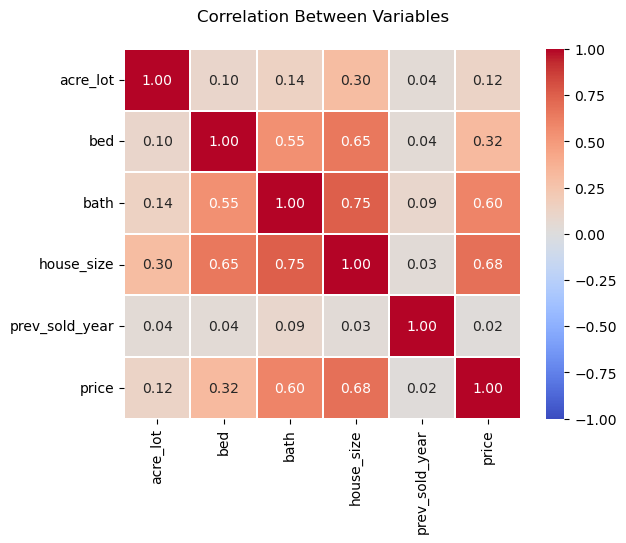

In [10]:
sns.heatmap(correlation, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)
plt.title("Correlation Between Variables", pad=20)

#### Create a variable to hold the features that correlate with the price feature between 0.20 and 0.80

In [11]:
'''
'''
savefeatures = ["latitude","longitude"]
for feature, value in correlation["price"].items():
    if abs(value) < 0.81 and abs(value) >= 0.20:
        savefeatures.append(feature)

print(savefeatures)

['latitude', 'longitude', 'bed', 'bath', 'house_size']


#### Create common variables to store frequently used values.

In [12]:
#features = ["latitude","longitude","bed","bath","house_size"]
features = savefeatures
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [13]:
X = normalize_df[savefeatures]
y = normalize_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [14]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [15]:
def results_dict_append(rtnval):
    results_dict["model"].append(rtnval["model"])
    results_dict["explained variance score"].append(rtnval["explained variance score"])
    results_dict["mae score"].append(rtnval["mae score"])
    results_dict["mse score"].append(rtnval["mse score"])
    results_dict["r2 score"].append(rtnval["r2 score"])
    results_dict["mean fit time"].append(rtnval["mean fit time"])

#### Ada Boosting

In [16]:
adaboost = dosomething("Ada Boost","Ada Boost", normalize_df, features, "price")
results_dict_append(adaboost["results"])
adaboost_predict = adaboost["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size']
Ada Boost EVS = -0.863496245
Ada Boost MSE = 1.160741
Ada Boost MAE = 0.709294
Ada Boost R2 = -1.187364
Ada Boost Fit Time = 0.021404409408569337


#### Gradient Boosting

In [17]:
gbr = dosomething("Gradient Boosting","Gradient Boosting", normalize_df, features, "price")
results_dict_append(gbr["results"])
gbr_predict = gbr["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size']
Gradient Boosting EVS = -0.480421294
Gradient Boosting MSE = 0.804573
Gradient Boosting MAE = 0.519072
Gradient Boosting R2 = -0.516181
Gradient Boosting Fit Time = 0.02530961036682129


#### Hist Gradient Boosting

In [18]:
histgbr = dosomething("Hist Gradient Boosting","Hist Gradient Boosting", normalize_df, features, "price")
results_dict_append(histgbr["results"])
histgbr_predict = histgbr["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size']
Hist Gradient Boosting EVS = 0.492989717
Hist Gradient Boosting MSE = 0.280372
Hist Gradient Boosting MAE = 0.421461
Hist Gradient Boosting R2 = 0.471652
Hist Gradient Boosting Fit Time = 0.09345240592956543


#### Random Forest

In [19]:
rf = dosomething("Random Forest","Random Forest", normalize_df, features, "price")
results_dict_append(rf["results"])
rf_predict = rf["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'bath', 'house_size']
Random Forest EVS = -0.513024336
Random Forest MSE = 0.841728
Random Forest MAE = 0.559112
Random Forest R2 = -0.586198
Random Forest Fit Time = 0.07411670684814453


#### Graphing the results works best when the data is provided in a DataFrame.

In [20]:
adaboost_predict_df = pd.DataFrame(adaboost_predict).reset_index()
adaboost_predict_df.rename(columns={0: "prediction"},inplace=True)

gbr_predict_df = pd.DataFrame(gbr_predict).reset_index()
gbr_predict_df.rename(columns={0: "prediction"},inplace=True)

rf_predict_df = pd.DataFrame(rf_predict).reset_index()
rf_predict_df.rename(columns={0: "prediction"},inplace=True)

histgbr_predict_df = pd.DataFrame(histgbr_predict).reset_index()
histgbr_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

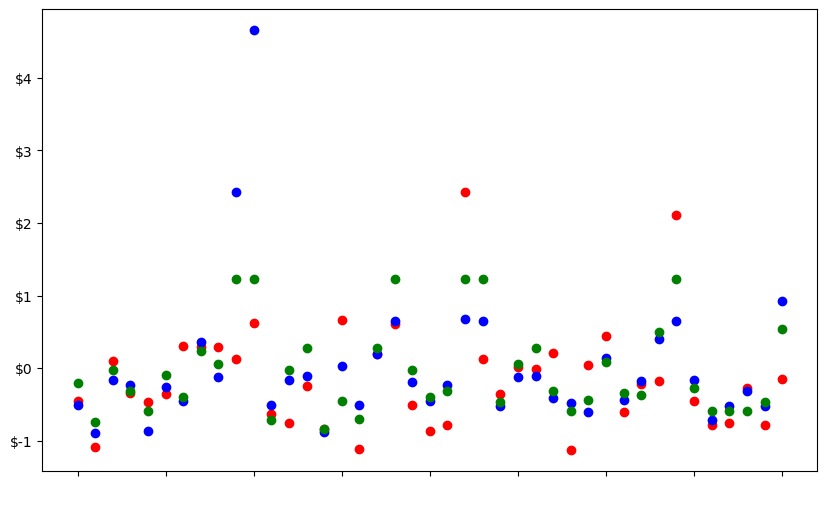

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(gbr_predict_df.index,gbr_predict_df["prediction"], color="blue")
plt.scatter(histgbr_predict_df.index,histgbr_predict_df["prediction"], color="green")
#plt.scatter(adaboost_predict_df.index,adaboost_predict_df["prediction"], color="black")
#plt.scatter(rf_predict_df.index,rf_predict_df["prediction"], color="black")
plt.show()

#### Output the results so they can be copied into another Notebook comparing the results of all the models.

In [22]:
results_dict

{'model': ['Ada Boost',
  'Gradient Boosting',
  'Hist Gradient Boosting',
  'Random Forest'],
 'explained variance score': ['-0.863496245',
  '-0.480421294',
  '0.492989717',
  '-0.513024336'],
 'mae score': ['0.709294', '0.519072', '0.421461', '0.559112'],
 'mse score': ['1.160741', '0.804573', '0.280372', '0.841728'],
 'r2 score': ['-1.187364', '-0.516181', '0.471652', '-0.586198'],
 'mean fit time': [0.021404409408569337,
  0.02530961036682129,
  0.09345240592956543,
  0.07411670684814453]}

In [23]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Ada Boost,-0.863496245,0.709294,1.160741,-1.187364,0.021404
Gradient Boosting,-0.480421294,0.519072,0.804573,-0.516181,0.025310
Hist Gradient Boosting,0.492989717,0.421461,0.280372,0.471652,0.093452
Random Forest,-0.513024336,0.559112,0.841728,-0.586198,0.074117
